In [1]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import dill

In [2]:
# verify kernel won't crash due to MKL issue from future imports
import sklearn.linear_model.tests.test_randomized_l1

# Plotting from section 13 of `2.1.1 run same mixtures through Cibersort for comparison.ipynb`

In [3]:
[
    merged_samples, cleaner_gt, friendly_mixture_descriptions, example_result,
    cib_class_names, rollup_groundtruth, rollupsums_df, col_order, rollups
] = pickle.load(open('logs/tmp_2.1.1_plotting.pkl', 'rb'))

In [4]:
print('Cibersort Diagnostics for hyper (inserted in google doc):')
for key,row in example_result[['RMSE', 'P-value']].iterrows():
    print("mixture %d" % (key+1))
    print("{{{mix%d_rmse:%0.2f}}}" % (key+1, row['RMSE']))
    print("{{{mix%d_pval:%0.1f}}}" % (key+1, row['P-value']))
example_result[['RMSE', 'P-value']].iloc[[6,1,9]]

Cibersort Diagnostics for hyper (inserted in google doc):
mixture 1
{{{mix1_rmse:0.28}}}
{{{mix1_pval:0.0}}}
mixture 2
{{{mix2_rmse:0.34}}}
{{{mix2_pval:0.0}}}
mixture 3
{{{mix3_rmse:0.30}}}
{{{mix3_pval:0.0}}}
mixture 4
{{{mix4_rmse:0.33}}}
{{{mix4_pval:0.0}}}
mixture 5
{{{mix5_rmse:0.27}}}
{{{mix5_pval:0.0}}}
mixture 6
{{{mix6_rmse:0.34}}}
{{{mix6_pval:0.0}}}
mixture 7
{{{mix7_rmse:0.45}}}
{{{mix7_pval:0.0}}}
mixture 8
{{{mix8_rmse:0.44}}}
{{{mix8_pval:0.0}}}
mixture 9
{{{mix9_rmse:0.41}}}
{{{mix9_pval:0.0}}}
mixture 10
{{{mix10_rmse:0.49}}}
{{{mix10_pval:0.0}}}


,RMSE,P-value
6,0.452792,0.0
1,0.339896,0.0
9,0.486806,0.0


In [17]:
#sns.set_context('paper')
sns.set_style("darkgrid")

In [8]:
def savefig(fig, *args, **kwargs):
    """
    Wrap figure.savefig defaulting to tight bounding box.
    From https://github.com/mwaskom/seaborn/blob/dfdd1126626f7ed0fe3737528edecb71346e9eb0/seaborn/axisgrid.py#L1840
    """
    kwargs.setdefault("bbox_inches", "tight")
    fig.savefig(*args, **kwargs)

In [9]:
def extract_values_for_mixture_by_id(key):
    """
    key: 1-indexed, meaning mixture 1 to mixture 10
    
    based on:
    for (key, grp), \
            (_, groundtruth_base), \
            friendly_title, \
            (_, cib_vals_base), \
            (mixID_rolledup, groundtruth_rolledup), \
            (_, cib_vals_rolledup) in zip(merged_samples.groupby('sample_id'),
                                          cleaner_gt.iterrows(),
                                          #friendly_mixture_descriptions2,
                                          friendly_mixture_descriptions,
                                          example_result[cib_class_names].iterrows(),
                                          rollup_groundtruth.groupby('mixID'),
                                          rollupsums_df.iterrows()
    """
    grp = merged_samples[merged_samples['sample_id'] == key]
    groundtruth_base = cleaner_gt.iloc[key-1]
    cib_vals_base = example_result[cib_class_names].iloc[key-1]
    groundtruth_rolledup = rollup_groundtruth[rollup_groundtruth['mixID'] == key-1]
    cib_vals_rolledup = rollupsums_df.iloc[key-1]
    
    return (key, grp, groundtruth_base, cib_vals_base, groundtruth_rolledup, cib_vals_rolledup)

In [10]:
def plot_single_mixture_results(mixture_info, friendly_title):
    #flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"] # http://seaborn.pydata.org/tutorial/color_palettes.html
    #sns.palplot(flatui)
    paired_colors = sns.color_palette("Paired_r", 12)
    #sns.palplot(paired_colors)
    
    (key, grp, groundtruth_base, cib_vals_base, groundtruth_rolledup, cib_vals_rolledup) = mixture_info

    with sns.plotting_context('paper'):
        f, ax = plt.subplots( figsize=(12,8))
        g = sns.boxplot(data = grp,
                       y='subset_name',
                       x='estimate',
                       ax=ax,
                       hue='type',
                       order=col_order,
                        # some additional parameters that we think may help:
                        saturation=1,
                        linewidth=1, # not sure about this one
                        dodge=False, # avoid hue nesting
                       #palette=[flatui[0], flatui[1]]
                        palette=paired_colors[0:2]
                       )
        g.set_title(friendly_title) 

        # ground truth
        gt1 = pd.DataFrame(groundtruth_base).reset_index()
        gt1.columns = ['rollup', 'estimate']
        gt1['type'] = 'subset'
        gt2 = groundtruth_rolledup[['rollup', 'estimate']].copy()
        gt2['type'] = 'rollup'
        gt = pd.concat([gt1, gt2])

        sns.stripplot(
            x="estimate",
            y="rollup",
            data=gt,
            hue='type',
            order=col_order,
            linewidth=0,
            size=15,
            alpha=.9,
            marker=(5, 1),
            #palette=[flatui[5], flatui[3]],
            palette=paired_colors[2:4],
            zorder=5,
            jitter=False,
            label='Ground Truth' # https://github.com/mwaskom/seaborn/issues/940 -- without this line, the stars aren't shown in legend entries made by "hue" param; instead you get a ton of dupe Ground Truth star labels
        )

        # add cibersort points
        cb_base = pd.DataFrame(cib_vals_base).reset_index()
        cb_base.columns = ['SubSet', 'estimate']
        cb_base['type'] = 'subset'

        cb_rolledup = pd.DataFrame(cib_vals_rolledup).reset_index()
        cb_rolledup.columns = ['SubSet', 'estimate']
        cb_rolledup['type'] = 'rollup'

        cb = pd.concat([cb_base, cb_rolledup])
        cb.SubSet = cb.SubSet.str.replace('_', ' ') # normalize names

        sns.stripplot(
            x="estimate",
            y="SubSet",
            data=cb,
            hue='type',
            order=col_order,
            linewidth=0,
            size=15,
            alpha=.9,
            marker=(3, 0),
            #palette=[flatui[2], flatui[4]],
            palette=paired_colors[4:6],
            zorder=6,
            jitter=False,
            label='Cibersort' # see above again re this label parameter
        )

        g.set_xlabel('Mixture proportion')
        g.set_ylabel('Cell type')
        g.set_xbound(0, 1)

        # show legend, and subselect because stripplot adds one legend item per point it appears
        handles, labels = ax.get_legend_handles_labels()
        """
        want legend items:
        * infino samples: items 0, 1
        * ground truth stars: items 2, 3
        * cibersort triangles: items 2+len(col_order)+2, 2+len(col_order)+2+1
        """
        chosen_idx = [1,0, 2,3, 2+len(col_order)+2, 2+len(col_order)+2+1]
        chosen_handles = [handles[i] for i in chosen_idx]
        #chosen_labels = [labels[i] for i in chosen_idx]
        chosen_labels = ['Infino (sums)', 'Infino', 'Ground Truth (sums)', 'Ground Truth', 'Cibersort (sums)', 'Cibersort']
        legend = ax.legend(
            chosen_handles,
            chosen_labels,
            loc='lower right',
            frameon=True)
        frame = legend.get_frame()
        frame.set_edgecolor('red')
        frame.set_facecolor('white')

        # shade background
        #fill1 = plt.axhspan('B', 'CD4 T', facecolor='0.5', alpha=0.5)
        fill1 = plt.axhspan(-0.5, 3.5, facecolor='0.8', alpha=0.3)
        fill3 = plt.axhspan(11.5, 15.5, facecolor='0.8', alpha=0.3)

        # improve label format
        # https://stackoverflow.com/a/34426167/130164
        for label in ax.get_yticklabels():
            if label.get_text() in rollups.keys():
                label.set_size(15)
                label.set_backgroundcolor("yellow")
                label.set_weight("bold")
                label.set_color("red")
            else:
                label.set_fontstyle("italic")
                label.set_weight("bold")


        return f,ax
        

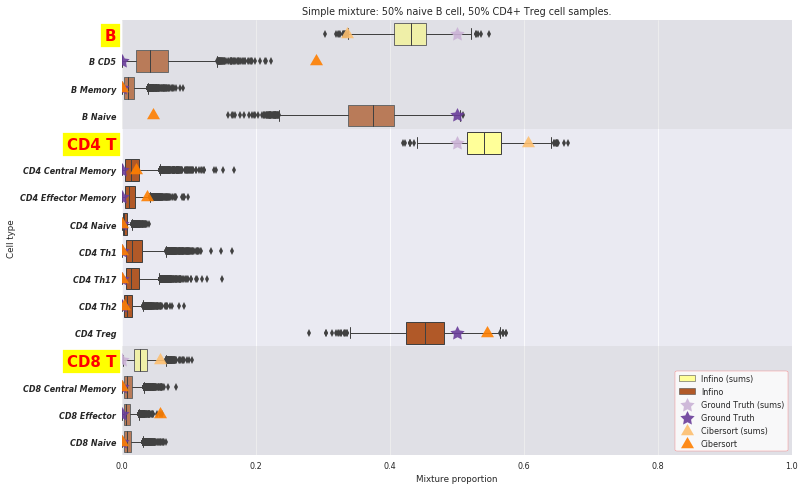

In [11]:
f,ax = plot_single_mixture_results(extract_values_for_mixture_by_id(7),
                                   'Simple mixture: 50% naive B cell, 50% CD4+ Treg cell samples.')

# New plots

these are some examples of the posterior-interval summary plots in R: http://mc-stan.org/bayesplot/articles/plotting-mcmc-draws.html#posterior-uncertainty-intervals

seaborn example: https://seaborn.pydata.org/examples/kde_joyplot.html

> may want to center on true value. just center x axis at 0 == truth. to check single parameter across multiple runs.
> (if you’re summarising  a single run (across cell types), then no need to center)

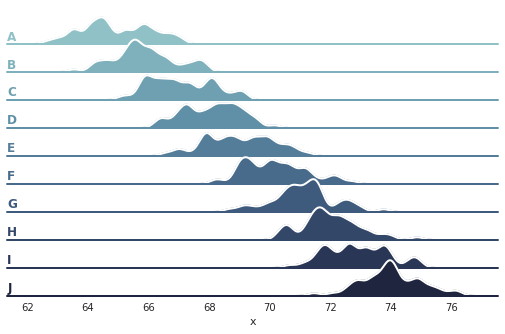

In [34]:
# based on https://seaborn.pydata.org/examples/kde_joyplot.html

# this line's rc settings make a huge difference
# sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# axes.facecolor is "color of the area where the data are drawn"
with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    # Create the data
    rs = np.random.RandomState(1979)
    x = rs.randn(500)
    g = np.tile(list("ABCDEFGHIJ"), 50)
    df = pd.DataFrame(dict(x=x, g=g))
    m = df.g.map(ord)
    df["x"] += m

    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df, row="g", hue="g", aspect=15, size=.5, palette=pal)

    ## Draw the densities in a few steps
    # this is the shaded area
    g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
    # this is the outline line of the top of the distribution
    g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2) 
    # this is the dividing horizontal line
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color, 
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "x")

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)
    
    # Instead, disabling overlap.
    # Some `subplots_adjust` line is necessary. without this, nothing appears
    #g.fig.subplots_adjust(hspace=0)

    # Remove axes details that don't play will with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)

TypeError: __init__() got an unexpected keyword argument 'ax'

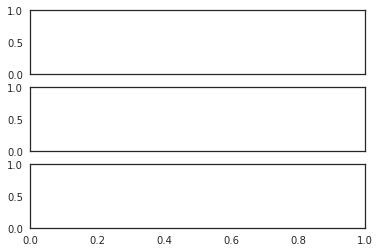

In [35]:
# now try this with three stacked plots (we want to break into CD4 plot, CD8 plot, B cell plot)

with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    f, axarr = plt.subplots(3, sharex=True)
    
    # Create the data
    rs = np.random.RandomState(1979)
    x = rs.randn(500)
    g = np.tile(list("ABCDEFGHIJ"), 50)
    df = pd.DataFrame(dict(x=x, g=g))
    m = df.g.map(ord)
    df["x"] += m

    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    
    for ax in axarr:
        g = sns.FacetGrid(df, row="g", hue="g", aspect=15, size=.5, palette=pal, ax=ax)

        ## Draw the densities in a few steps
        # this is the shaded area
        g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
        # this is the outline line of the top of the distribution
        g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2) 
        # this is the dividing horizontal line
        g.map(plt.axhline, y=0, lw=2, clip_on=False)

        # Define and use a simple function to label the plot in axes coordinates
        def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, label, fontweight="bold", color=color, 
                    ha="left", va="center", transform=ax.transAxes)

        g.map(label, "x")

        # Set the subplots to overlap
        g.fig.subplots_adjust(hspace=-.25)

        # Instead, disabling overlap.
        # Some `subplots_adjust` line is necessary. without this, nothing appears
        #g.fig.subplots_adjust(hspace=0)

        # Remove axes details that don't play will with overlap
        g.set_titles("")
        g.set(yticks=[])
        g.despine(bottom=True, left=True)



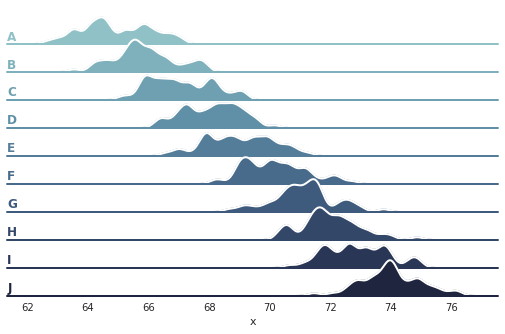

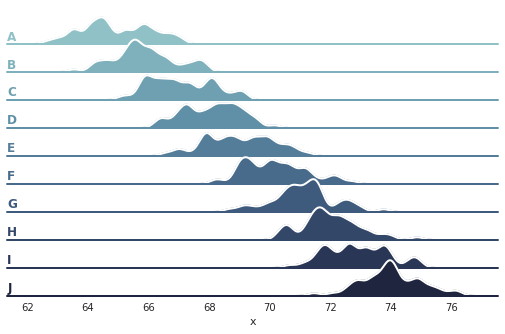

In [55]:
def gen_plot():
    with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
        g = sns.FacetGrid(df, row="g", hue="g", aspect=15, size=.5, palette=pal)

        ## Draw the densities in a few steps
        # this is the shaded area
        g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
        # this is the outline line of the top of the distribution
        g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2) 
        # this is the dividing horizontal line
        g.map(plt.axhline, y=0, lw=2, clip_on=False)

        # Define and use a simple function to label the plot in axes coordinates
        def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, label, fontweight="bold", color=color, 
                    ha="left", va="center", transform=ax.transAxes)

        g.map(label, "x")

        # Set the subplots to overlap
        g.fig.subplots_adjust(hspace=-.25)

        # Instead, disabling overlap.
        # Some `subplots_adjust` line is necessary. without this, nothing appears
        #g.fig.subplots_adjust(hspace=0)

        # Remove axes details that don't play will with overlap
        g.set_titles("")
        g.set(yticks=[])
        g.despine(bottom=True, left=True)
        return g
g1 = gen_plot()
g2 = gen_plot()

[Figures can't be merged](https://stackoverflow.com/a/44159496/130164). Oops.

But: FacetGrid allows for multi-dimensional levels. There's `hue`, `row`, and `col`. We're not using `col` above, so let's add two `col` levels and plot the facetgrids side by side:

In [37]:
df.head()

,g,x
0,A,64.038123
1,B,66.147050
2,C,66.370011
3,D,68.791019
4,E,70.583534


In [43]:
df1 = df.copy()
df2 = df.copy()
df3 = df.copy()
df1['copynum'] = 1
df2['copynum'] = 2
df3['copynum'] = 3
merged_df = pd.concat([df1, df2, df3])
merged_df.head()

,g,x,copynum
0,A,64.038123,1
1,B,66.147050,1
2,C,66.370011,1
3,D,68.791019,1
4,E,70.583534,1


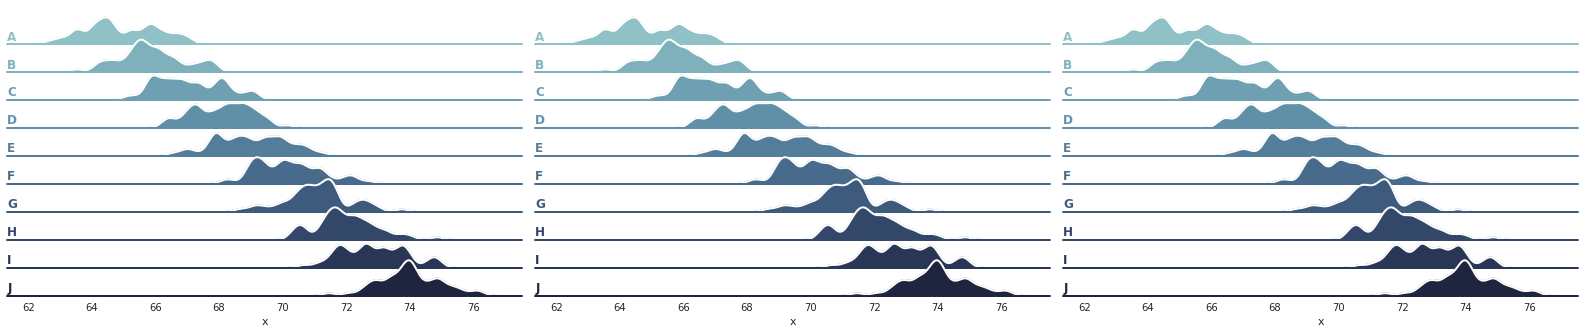

In [56]:
def gen_plot():
    with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
        g = sns.FacetGrid(merged_df, row="g", hue="g", aspect=15, size=.5, palette=pal,
                         col='copynum')

        ## Draw the densities in a few steps
        # this is the shaded area
        g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
        # this is the outline line of the top of the distribution
        g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2) 
        # this is the dividing horizontal line
        g.map(plt.axhline, y=0, lw=2, clip_on=False)

        # Define and use a simple function to label the plot in axes coordinates
        def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, label, fontweight="bold", color=color, 
                    ha="left", va="center", transform=ax.transAxes)

        g.map(label, "x")

        # Set the subplots to overlap
        g.fig.subplots_adjust(hspace=-.25)

        # Instead, disabling overlap.
        # Some `subplots_adjust` line is necessary. without this, nothing appears
        #g.fig.subplots_adjust(hspace=0)

        # Remove axes details that don't play will with overlap
        g.set_titles("")
        g.set(yticks=[])
        g.despine(bottom=True, left=True)
        return g
gen_plot()

So this works to give us our B cell, T-CD4, and T-CD8 plots.

But FacetGrid might not be flexible enough to allow us to also plot rollups in a different color. That might require setting `hue` to a new column that we define manually, and specifying a palette manually (as we did before). Or might have to break out of this and just make the subplots ourselves...

In [47]:
# hue will be set to J for J rows and A for all other rows
df['hue'] = df['g'].apply(lambda h: 'J' if h == 'J' else 'A')
df.hue.value_counts()

A    450
J     50
Name: hue, dtype: int64

In [48]:
df1 = df.copy()
df2 = df.copy()
df3 = df.copy()
df1['copynum'] = 1
df2['copynum'] = 2
df3['copynum'] = 3
merged_df = pd.concat([df1, df2, df3])
merged_df.head()

,g,x,hue,copynum
0,A,64.038123,A,1
1,B,66.147050,A,1
2,C,66.370011,A,1
3,D,68.791019,A,1
4,E,70.583534,A,1


In [50]:
merged_df.hue.value_counts()

A    1350
J     150
Name: hue, dtype: int64

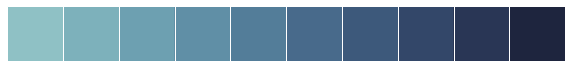

In [51]:
sns.palplot(pal)

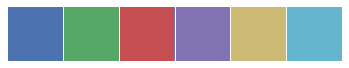

In [52]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

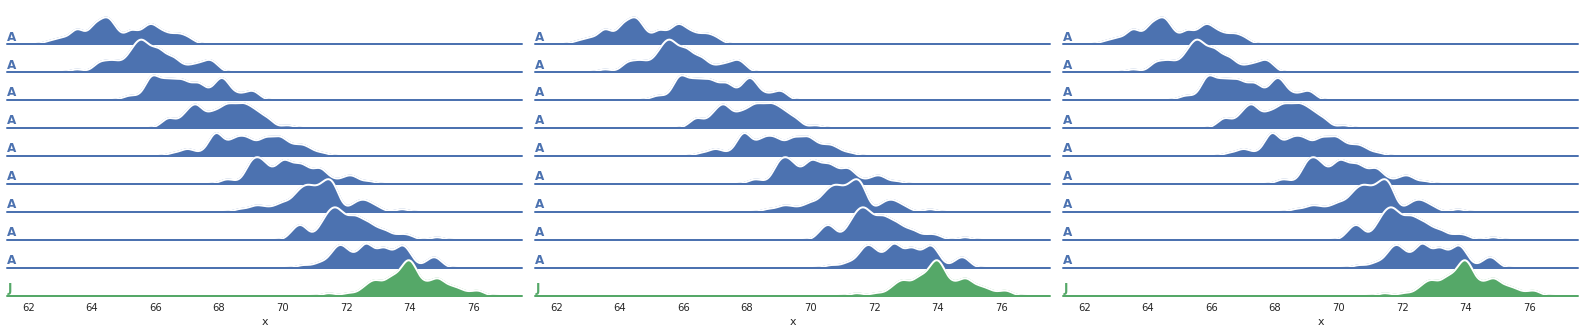

In [57]:
def gen_plot2():
    with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
        g = sns.FacetGrid(merged_df, row="g", hue="hue", aspect=15, size=.5,
                          #palette=pal,
                          palette=current_palette,
                         col='copynum')

        ## Draw the densities in a few steps
        # this is the shaded area
        g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
        # this is the outline line of the top of the distribution
        g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2) 
        # this is the dividing horizontal line
        g.map(plt.axhline, y=0, lw=2, clip_on=False)

        # Define and use a simple function to label the plot in axes coordinates
        def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, label, fontweight="bold", color=color, 
                    ha="left", va="center", transform=ax.transAxes)

        g.map(label, "x")

        # Set the subplots to overlap
        g.fig.subplots_adjust(hspace=-.25)

        # Instead, disabling overlap.
        # Some `subplots_adjust` line is necessary. without this, nothing appears
        #g.fig.subplots_adjust(hspace=0)

        # Remove axes details that don't play will with overlap
        g.set_titles("")
        g.set(yticks=[])
        g.despine(bottom=True, left=True)
        return g
gen_plot2()

It'd be nice to have a slowly-changing palette like `pal` for the subsets, then tack on a bold color like green from `current_palette` for the rollup.

A problem with the above is that the row labels are coming from `hue` not `row`.

In [65]:
merged_df.head()

,g,x,hue,copynum
0,A,64.038123,A,1
1,B,66.147050,A,1
2,C,66.370011,A,1
3,D,68.791019,A,1
4,E,70.583534,A,1


(0      64.038123
10     65.723433
20     67.067787
30     65.215980
40     66.707504
50     65.631442
60     66.684976
70     63.015903
80     64.106152
90     64.443467
100    65.181087
110    64.466540
120    63.080895
130    64.119624
140    64.484735
150    64.007184
160    65.196320
170    63.649979
180    66.444729
190    65.938141
200    64.507826
210    67.004673
220    64.630121
230    63.480782
240    63.670576
250    66.018931
260    66.203872
270    65.960129
280    64.713854
290    64.199111
300    64.839984
310    66.754530
320    62.671687
330    64.086624
340    66.226185
350    65.858129
360    63.413301
370    65.282763
380    64.430808
390    65.601947
400    65.784255
410    66.339326
420    63.522999
430    64.559755
440    65.844975
450    64.243303
460    65.340230
470    64.413991
480    63.521875
490    64.724145
Name: x, dtype: float64, 0      A
10     A
20     A
30     A
40     A
50     A
60     A
70     A
80     A
90     A
100    A
110    A
120    A
130    

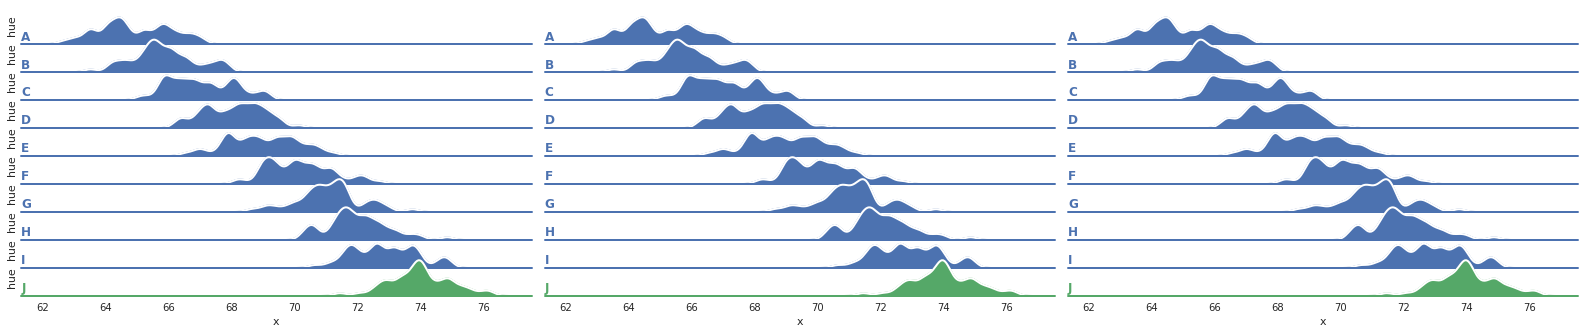

In [73]:
with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    g = sns.FacetGrid(merged_df, row="g", hue="hue", aspect=15, size=.5,
                      #palette=pal,
                      palette=current_palette,
                     col='copynum')

    ## Draw the densities in a few steps
    # this is the shaded area
    g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
    # this is the outline line of the top of the distribution
    g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2) 
    # this is the dividing horizontal line
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    #def label(x, color, label, g):
        #print(g)
    #def label(x, color, label):
    def label(*args, **kwargs):
        #x = kwargs['data']
        print(args)
        print(kwargs)
        #color = args[1]
        #label = args[2]
        color = kwargs['color']
        label = args[-1].iloc[0]
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color, 
                ha="left", va="center", transform=ax.transAxes)

    #g.map(label, "x", color='hue', label='g')
    g.map(label, "x", 'hue', 'g')

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    # Instead, disabling overlap.
    # Some `subplots_adjust` line is necessary. without this, nothing appears
    #g.fig.subplots_adjust(hspace=0)

    # Remove axes details that don't play will with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)

```
For even more customization, you can work directly with the underling matplotlib Figure and Axes objects, which are stored as member attributes at fig and axes (a two-dimensional array), respectively. When making a figure without row or column faceting, you can also use the ax attribute to directly access the single axes.

g = sns.FacetGrid(tips, col="smoker", margin_titles=True, size=4)
g.map(plt.scatter, "total_bill", "tip", color="#338844", edgecolor="white", s=50, lw=1)
for ax in g.axes.flat:
    ax.plot((0, 50), (0, .2 * 50), c=".2", ls="--")
g.set(xlim=(0, 60), ylim=(0, 14));
```

In [82]:
mymix = extract_values_for_mixture_by_id(7)
paired_colors = sns.color_palette("Paired_r", 12)
(key, grp, groundtruth_base, cib_vals_base, groundtruth_rolledup, cib_vals_rolledup) = mymix
grp=grp.copy()
grp.head()

,sample_id,combined_iter_number,subset_name,estimate,type
49000,7,0,B CD5,0.027472,subset
49001,7,1,B CD5,0.061270,subset
49002,7,2,B CD5,0.031252,subset
49003,7,3,B CD5,0.046982,subset
49004,7,4,B CD5,0.036124,subset


In [83]:
grp.subset_name.value_counts()

CD8 Effector           4000
CD4 Effector Memory    4000
B Memory               4000
CD8 T                  4000
CD4 Th17               4000
CD4 Th1                4000
CD4 Treg               4000
CD4 T                  4000
CD4 Th2                4000
CD4 Naive              4000
B CD5                  4000
CD4 Central Memory     4000
B                      4000
CD8 Naive              4000
CD8 Central Memory     4000
B Naive                4000
Name: subset_name, dtype: int64

In [84]:
grp['supertype'] = grp['subset_name'].apply(lambda x: 'CD4 T' if 'CD4' in x else 'CD8 T' if 'CD8' in x else 'B')
grp.supertype.value_counts()

CD4 T    32000
CD8 T    16000
B        16000
Name: supertype, dtype: int64

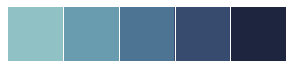

In [106]:
sns.palplot(sns.cubehelix_palette(5, start=0, rot=-.25, light=.7))

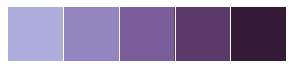

In [92]:
sns.palplot(sns.cubehelix_palette(5, start=0.5, rot=-.25, light=.7))

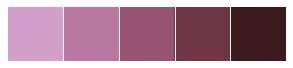

In [96]:
sns.palplot(sns.cubehelix_palette(5, start=1, rot=-.25, light=.7))

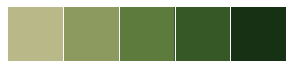

In [97]:
sns.palplot(sns.cubehelix_palette(5, start=2, rot=-.25, light=.7))

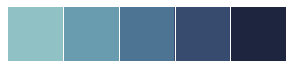

In [98]:
sns.palplot(sns.cubehelix_palette(5, start=3, rot=-.25, light=.7))

['B CD5',
 'B Memory',
 'B Naive',
 'B',
 'CD4 Central Memory',
 'CD4 Effector Memory',
 'CD4 Naive',
 'CD4 Th1',
 'CD4 Th17',
 'CD4 Th2',
 'CD4 Treg',
 'CD4 T',
 'CD8 Central Memory',
 'CD8 Effector',
 'CD8 Naive',
 'CD8 T']

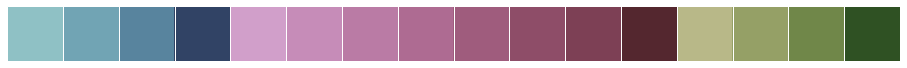

In [109]:
hue_order = []
built_palette = []
for r, start in zip(list(rollups), range(0,3)):
    hue_order.extend(rollups[r])
    hue_order.append(r)
    full_pal = sns.cubehelix_palette(len(rollups[r]) + 3,
                                     start=start,
                                     rot=-.25,
                                     light=.7)
    # first #subtypes colors
    built_palette.extend(full_pal[:len(rollups[r])])
    # then a darker color (but not the darkest)
    built_palette.append(full_pal[-2])
hue_order = [h.replace('_', ' ') for h in hue_order]
sns.palplot(built_palette)
hue_order

In [110]:
grp.head()

,sample_id,combined_iter_number,subset_name,estimate,type,supertype
49000,7,0,B CD5,0.027472,subset,B
49001,7,1,B CD5,0.061270,subset,B
49002,7,2,B CD5,0.031252,subset,B
49003,7,3,B CD5,0.046982,subset,B
49004,7,4,B CD5,0.036124,subset,B


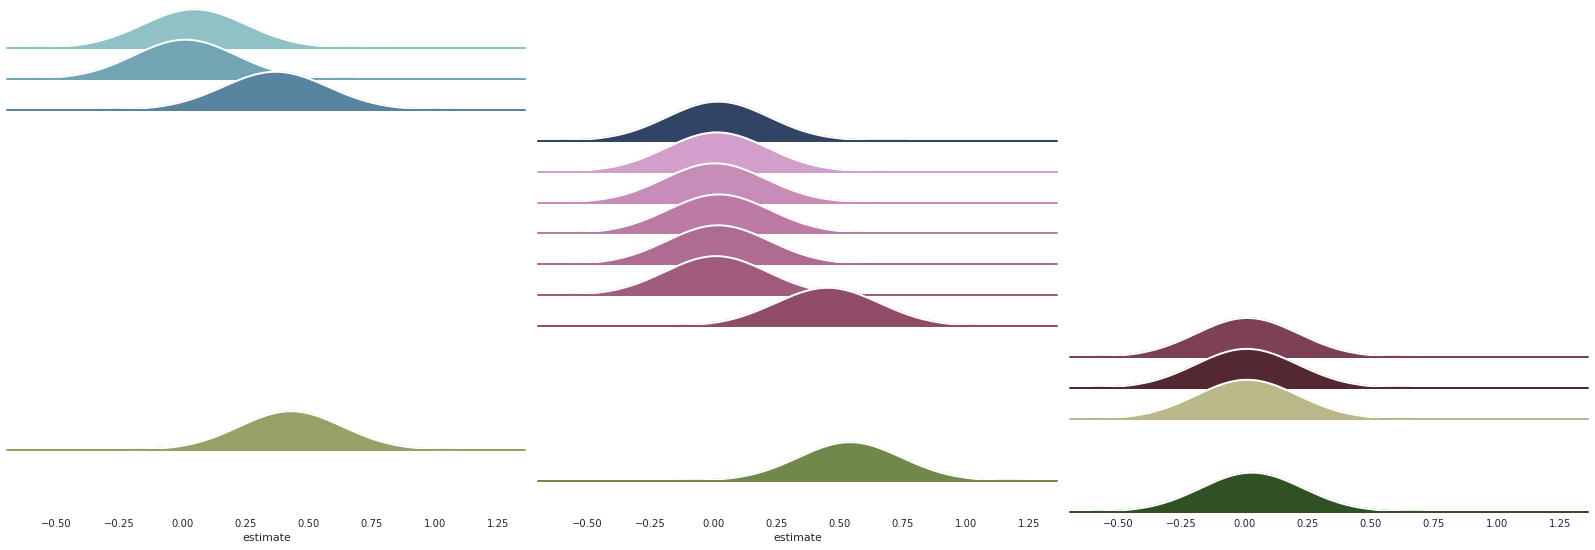

In [113]:
with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    g = sns.FacetGrid(grp,
                      row="subset_name",
                      hue="subset_name",
                      col="supertype",
                      aspect=15,
                      size=.5,
                      palette=built_palette
                     )

    ## Draw the densities in a few steps
    # this is the shaded area
    g.map(sns.kdeplot, "estimate", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
    # this is the outline line of the top of the distribution
    g.map(sns.kdeplot, "estimate", clip_on=False, color="w", lw=2, bw=.2) 
    # this is the dividing horizontal line
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

 

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    # Instead, disabling overlap.
    # Some `subplots_adjust` line is necessary. without this, nothing appears
    #g.fig.subplots_adjust(hspace=0)

    # Remove axes details that don't play will with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)

In [151]:
# max level
len(rollups['CD4 T'])

7

In [164]:
map_row_to_ylevel = {}
for k in rollups:
    map_row_to_ylevel[k] = 0
    for v,s in zip(rollups[k], range(1, len(rollups[k]) + 1)):
        map_row_to_ylevel[v.replace('_', ' ')] = s
map_row_to_ylevel

{'B': 0,
 'B CD5': 1,
 'B Memory': 2,
 'B Naive': 3,
 'CD4 Central Memory': 1,
 'CD4 Effector Memory': 2,
 'CD4 Naive': 3,
 'CD4 T': 0,
 'CD4 Th1': 4,
 'CD4 Th17': 5,
 'CD4 Th2': 6,
 'CD4 Treg': 7,
 'CD8 Central Memory': 1,
 'CD8 Effector': 2,
 'CD8 Naive': 3,
 'CD8 T': 0}

In [165]:
grp['ylevel'] = grp['subset_name'].apply(lambda x: map_row_to_ylevel[x])
grp.ylevel.value_counts()

3    12000
2    12000
1    12000
0    12000
7     4000
6     4000
5     4000
4     4000
Name: ylevel, dtype: int64

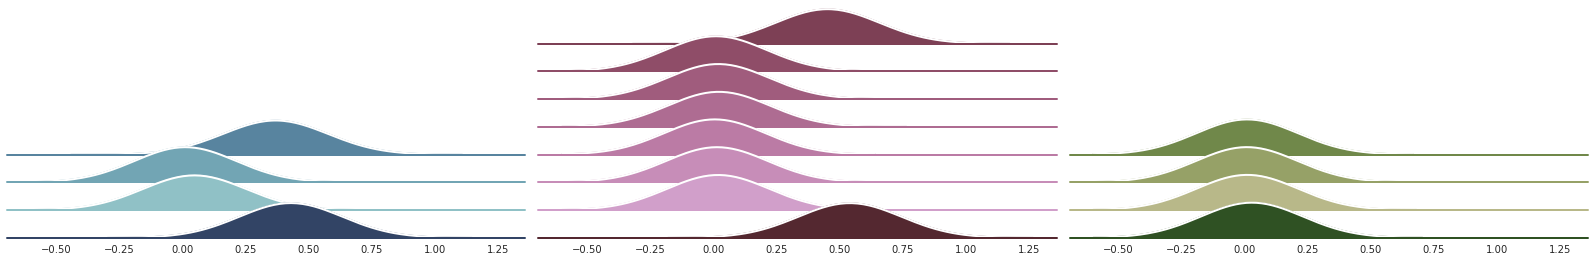

In [168]:
with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    g = sns.FacetGrid(grp,
                      row="ylevel", # subset_name
                      hue="subset_name",
                      col="supertype",
                      row_order=reversed(list(range(grp.ylevel.values.max()+1))),
                      #row_order=hue_order,
                      hue_order=hue_order,
                      aspect=15,
                      size=.5,
                      palette=built_palette
                      #sharey=False
                     )

    ## Draw the densities in a few steps
    # this is the shaded area
    g.map(sns.kdeplot, "estimate", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
    # this is the outline line of the top of the distribution
    g.map(sns.kdeplot, "estimate", clip_on=False, color="w", lw=2, bw=.2) 
    # this is the dividing horizontal line
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

 

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    # Instead, disabling overlap.
    # Some `subplots_adjust` line is necessary. without this, nothing appears
    #g.fig.subplots_adjust(hspace=0)

    # Remove axes details that don't play will with overlap
    g.set_titles("")
    #g.set_titles(col_template="{col_name}", row_template="")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)

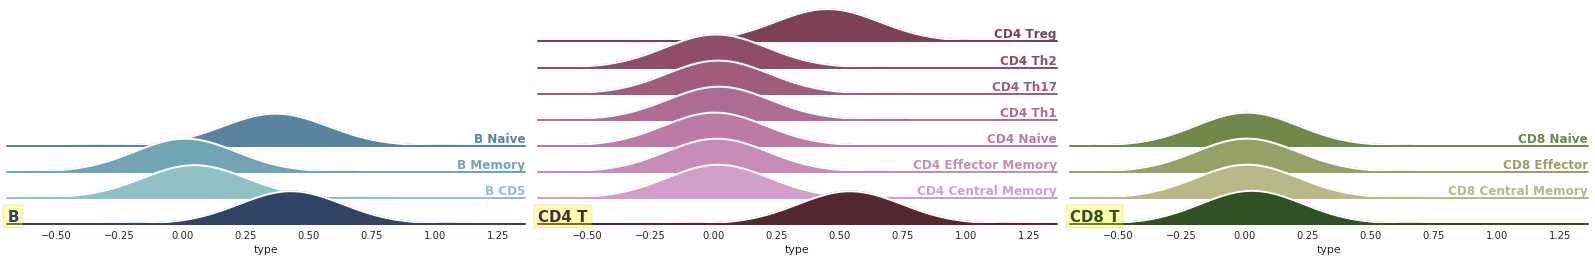

In [186]:
with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    g = sns.FacetGrid(grp,
                      row="ylevel", # subset_name
                      hue="subset_name",
                      col="supertype",
                      row_order=reversed(list(range(grp.ylevel.values.max()+1))),
                      #row_order=hue_order,
                      hue_order=hue_order,
                      aspect=15,
                      size=.5,
                      palette=built_palette
                      #sharey=False
                     )

    ## Draw the densities in a few steps
    # this is the shaded area
    g.map(sns.kdeplot, "estimate", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
    # this is the outline line of the top of the distribution
    g.map(sns.kdeplot, "estimate", clip_on=False, color="w", lw=2, bw=.2) 
    # this is the dividing horizontal line
    g.map(plt.axhline, y=0, lw=2, clip_on=False)
    
    def label(*args, **kwargs):
        """
        args[0] is a Series that corresponds to this facet. it will have values "subset" or "rollup"
        kwargs is e.g.: {'color': (0.4918017777777778, 0.25275644444444445, 0.3333333333333333), 'label': 'CD4 Treg'}
        """
        #print(args)
        #print(kwargs)
        type_of_label = args[0].values[0]
        color = kwargs['color']
        label = kwargs['label']
        ax = plt.gca() # map() changes current axis a ton
        if type_of_label == 'rollup':
            ax.text(0, .2,
                    label,
                    fontweight="bold",
                    color=color, 
                    ha="left", va="center", transform=ax.transAxes,
                    fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.3)
                   )
        else:
            ax.text(1, .2,
                    label,
                    fontweight="bold",
                    color=color, 
                    ha="right", va="center", transform=ax.transAxes
                   )
        
    g.map(label, "type")

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    # Instead, disabling overlap.
    # Some `subplots_adjust` line is necessary. without this, nothing appears
    #g.fig.subplots_adjust(hspace=0)

    # Remove axes details that don't play will with overlap
    g.set_titles("")
    #g.set_titles(col_template="{col_name}", row_template="")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)

original size: [ 22.5   4. ]


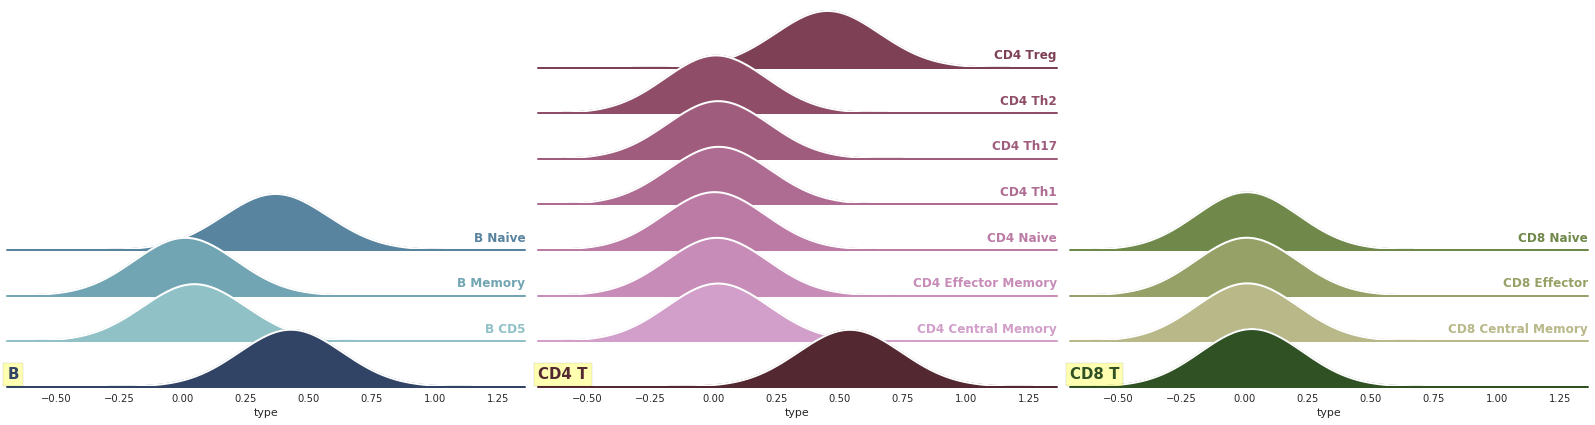

In [187]:
# resize
cur_size = g.fig.get_size_inches()
print("original size:", cur_size)
g.fig.set_size_inches(cur_size[0], cur_size[1] + 3)
g.fig

Overlay ground truth. 
Goal is to put lines. Also a marker point would be nice.

In [198]:
# ground truth
gt1 = pd.DataFrame(groundtruth_base).reset_index()
gt1.columns = ['rollup', 'estimate']
gt1['type'] = 'subset'
gt2 = groundtruth_rolledup[['rollup', 'estimate']].copy()
gt2['type'] = 'rollup'
gt = pd.concat([gt1, gt2])
gt['gt'] = gt['estimate']
del gt['estimate']
gt

,rollup,type,gt
0,B CD5,subset,0.0
1,B Memory,subset,0.0
2,B Naive,subset,0.5
3,CD4 Central Memory,subset,0.0
4,CD4 Effector Memory,subset,0.0
5,CD4 Naive,subset,0.0
6,CD4 Th1,subset,0.0
7,CD4 Th17,subset,0.0
8,CD4 Th2,subset,0.0
9,CD4 Treg,subset,0.5


In [199]:
all(x in grp.subset_name.unique() for x in gt.rollup)

True

In [202]:
merged_grp = pd.merge(grp, gt, left_on='subset_name', right_on='rollup', how='left')
merged_grp.head()

,sample_id,combined_iter_number,subset_name,estimate,type_x,supertype,ylevel,rollup,type_y,gt
0,7,0,B CD5,0.027472,subset,B,1,B CD5,subset,0.0
1,7,1,B CD5,0.061270,subset,B,1,B CD5,subset,0.0
2,7,2,B CD5,0.031252,subset,B,1,B CD5,subset,0.0
3,7,3,B CD5,0.046982,subset,B,1,B CD5,subset,0.0
4,7,4,B CD5,0.036124,subset,B,1,B CD5,subset,0.0


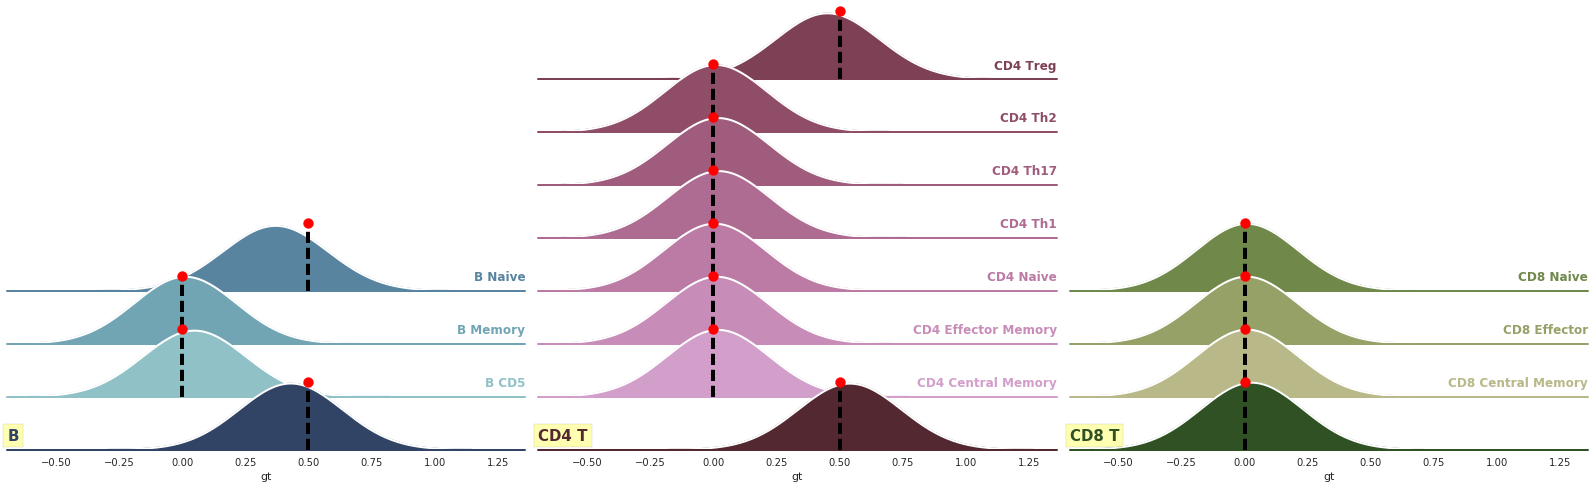

In [214]:
with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    g = sns.FacetGrid(merged_grp,
                      row="ylevel", # subset_name
                      hue="subset_name",
                      col="supertype",
                      row_order=reversed(list(range(grp.ylevel.values.max()+1))),
                      #row_order=hue_order,
                      hue_order=hue_order,
                      aspect=15,
                      size=.5,
                      palette=built_palette
                      #sharey=False
                     )

    ## Draw the densities in a few steps
    # this is the shaded area
    g.map(sns.kdeplot, "estimate", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
    # this is the outline line of the top of the distribution
    g.map(sns.kdeplot, "estimate", clip_on=False, color="w", lw=2, bw=.2) 
    # this is the dividing horizontal line
    g.map(plt.axhline, y=0, lw=2, clip_on=False)
    
    def label(*args, **kwargs):
        """
        args[0] is a Series that corresponds to this facet. it will have values "subset" or "rollup"
        kwargs is e.g.: {'color': (0.4918017777777778, 0.25275644444444445, 0.3333333333333333), 'label': 'CD4 Treg'}
        """
        #print(args)
        #print(kwargs)
        type_of_label = args[0].values[0]
        color = kwargs['color']
        label = kwargs['label']
        ax = plt.gca() # map() changes current axis a ton
        if type_of_label == 'rollup':
            ax.text(0, .2,
                    label,
                    fontweight="bold",
                    color=color, 
                    ha="left", va="center", transform=ax.transAxes,
                    fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.3)
                   )
        else:
            ax.text(1, .2,
                    label,
                    fontweight="bold",
                    color=color, 
                    ha="right", va="center", transform=ax.transAxes
                   )
        
    g.map(label, "type_x")
    
    def plot_gt(gt, **kwargs):
        # passed in a gt series
        # all values are the same, since we did a left merge
        # (there's only one gt value per facet)
        xval = gt.values[0]
        ymax = 2 # TODO: put in the y value of kde at the x value
        # plot
        ax = plt.gca()
        ax.scatter([xval], [ymax], s=100, c='r',zorder=10, clip_on=False) # clip_on=F means not clipped by axes limits
        ax.axvline(x=xval, ymin=0, ymax=ymax, lw=4, c='k', ls='dashed', clip_on=False) # lw=2
    
    g.map(plot_gt, "gt")

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    # Instead, disabling overlap.
    # Some `subplots_adjust` line is necessary. without this, nothing appears
    #g.fig.subplots_adjust(hspace=0)

    # Remove axes details that don't play will with overlap
    g.set_titles("")
    #g.set_titles(col_template="{col_name}", row_template="")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    
    # resize
    cur_size = g.fig.get_size_inches()
    increase_vertical = 4 # 3
    g.fig.set_size_inches(cur_size[0], cur_size[1] + increase_vertical)
    g.fig

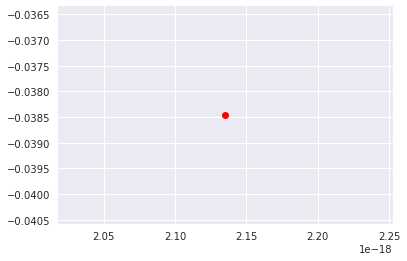

In [229]:
# try to reverse engineer kde values
tmpax = g.axes[1][1]
linedata = tmpax.get_lines()[0].get_data()
pathdata = tmpax.collections[-1].get_paths()
newf,newax = plt.subplots()
for path in pathdata:
    x, y = path.vertices.mean(axis=0)
    newax.plot(x, y, "ro")

In [230]:
pathdata

(Path(array([[ 0.        , -0.5       ],
        [ 0.13260155, -0.5       ],
        [ 0.25978994, -0.44731685],
        [ 0.35355339, -0.35355339],
        [ 0.44731685, -0.25978994],
        [ 0.5       , -0.13260155],
        [ 0.5       ,  0.        ],
        [ 0.5       ,  0.13260155],
        [ 0.44731685,  0.25978994],
        [ 0.35355339,  0.35355339],
        [ 0.25978994,  0.44731685],
        [ 0.13260155,  0.5       ],
        [ 0.        ,  0.5       ],
        [-0.13260155,  0.5       ],
        [-0.25978994,  0.44731685],
        [-0.35355339,  0.35355339],
        [-0.44731685,  0.25978994],
        [-0.5       ,  0.13260155],
        [-0.5       ,  0.        ],
        [-0.5       , -0.13260155],
        [-0.44731685, -0.25978994],
        [-0.35355339, -0.35355339],
        [-0.25978994, -0.44731685],
        [-0.13260155, -0.5       ],
        [ 0.        , -0.5       ],
        [ 0.        , -0.5       ]]), array([ 1,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4

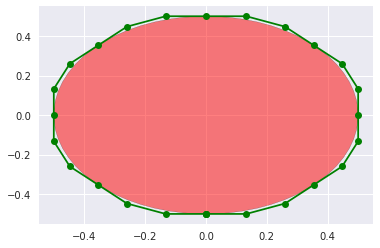

In [232]:
import matplotlib.patches as mpatches
patch = mpatches.PathPatch(pathdata[0], facecolor='r', alpha=0.5)
newf,newax = plt.subplots()

newax.add_patch(patch)

# plot control points and connecting lines
x, y = zip(*pathdata[0].vertices)
line, = newax.plot(x, y, 'go-')


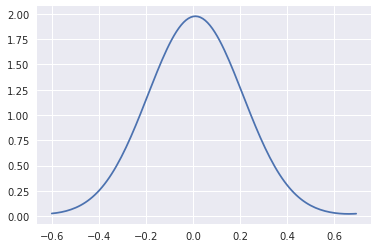

In [238]:
newf,newax = plt.subplots()
newax.plot(linedata[0], linedata[1])

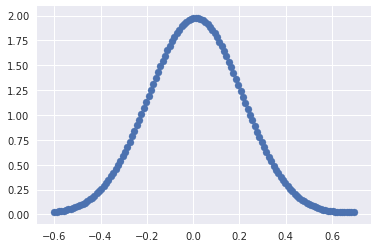

In [239]:
newf,newax = plt.subplots()
newax.scatter(linedata[0], linedata[1])

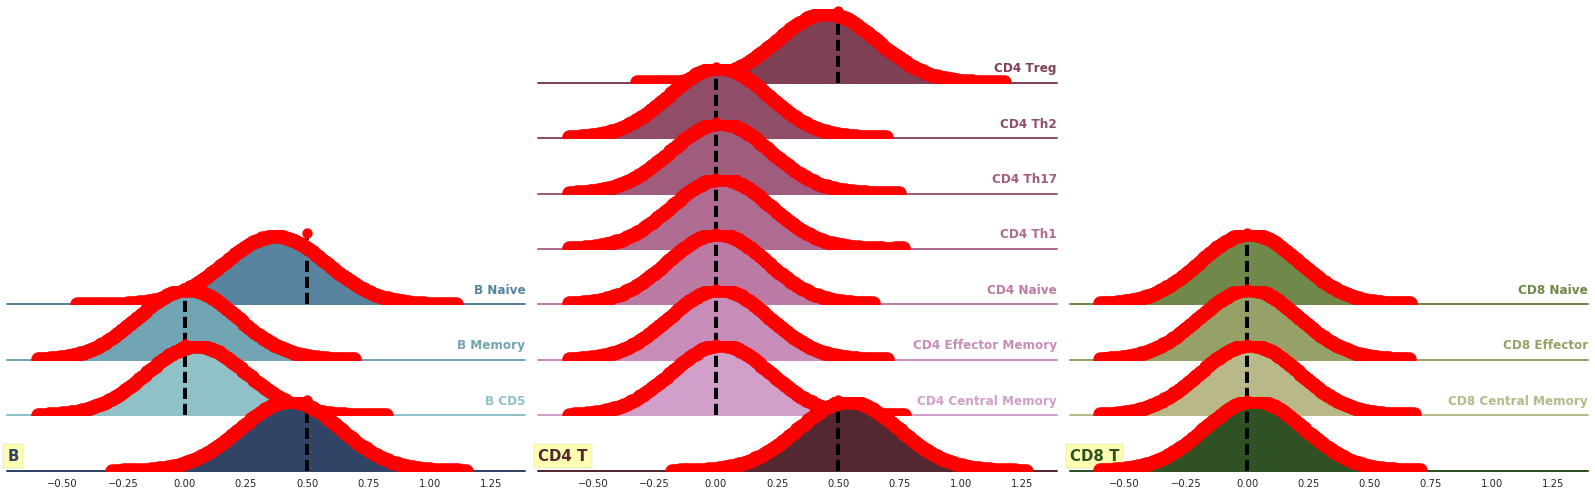

In [284]:
with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    g = sns.FacetGrid(merged_grp,
                      row="ylevel", # subset_name
                      hue="subset_name",
                      col="supertype",
                      row_order=reversed(list(range(grp.ylevel.values.max()+1))),
                      #row_order=hue_order,
                      hue_order=hue_order,
                      aspect=15,
                      size=.5,
                      palette=built_palette
                      #sharey=False
                     )

    ## Draw the densities in a few steps
    # this is the shaded area
    g.map(sns.kdeplot, "estimate", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
    # this is the outline line of the top of the distribution
    g.map(sns.kdeplot, "estimate", clip_on=False, color="w", lw=2, bw=.2) 
    # this is the dividing horizontal line
    g.map(plt.axhline, y=0, lw=2, clip_on=False)
    
    def label(*args, **kwargs):
        """
        args[0] is a Series that corresponds to this facet. it will have values "subset" or "rollup"
        kwargs is e.g.: {'color': (0.4918017777777778, 0.25275644444444445, 0.3333333333333333), 'label': 'CD4 Treg'}
        """
        #print(args)
        #print(kwargs)
        type_of_label = args[0].values[0]
        color = kwargs['color']
        label = kwargs['label']
        ax = plt.gca() # map() changes current axis a ton
        if type_of_label == 'rollup':
            ax.text(0, .2,
                    label,
                    fontweight="bold",
                    color=color, 
                    ha="left", va="center", transform=ax.transAxes,
                    fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.3)
                   )
        else:
            ax.text(1, .2,
                    label,
                    fontweight="bold",
                    color=color, 
                    ha="right", va="center", transform=ax.transAxes
                   )
        
    g.map(label, "type_x")
    
    def plot_gt(gt, **kwargs):
        # passed in a gt series
        # all values are the same, since we did a left merge
        # (there's only one gt value per facet)
        xval = gt.values[0]
        ymax = 2 # TODO: put in the y value of kde at the x value
        # plot
        ax = plt.gca()
        ax.scatter([xval], [ymax], s=100, c='r',zorder=10, clip_on=False) # clip_on=F means not clipped by axes limits
        ax.axvline(x=xval, ymin=0, ymax=ymax, lw=4, c='k', ls='dashed') # lw=2
    
    g.map(plot_gt, "gt")
    
    def confirm_extracting_kde(*args, **kwargs):
        ax = plt.gca()
        kde_line = ax.get_lines()[0].get_data()
        ax.scatter(kde_line[0], kde_line[1], c='r', s=200, zorder=200)
        
    g.map(confirm_extracting_kde)
        

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    # Instead, disabling overlap.
    # Some `subplots_adjust` line is necessary. without this, nothing appears
    #g.fig.subplots_adjust(hspace=0)

    # Remove axes details that don't play will with overlap
    g.set_titles("")
    #g.set_titles(col_template="{col_name}", row_template="")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    
    # resize
    cur_size = g.fig.get_size_inches()
    increase_vertical = 4 # 3
    g.fig.set_size_inches(cur_size[0], cur_size[1] + increase_vertical)
    g.fig

OK, we've figured out how to extract the kde points. Now let's interpolate from that point collection to figure out y value associated with an x value. The point of all this is to choose the right height for our groundtruth and cibersort lines.

In [277]:
def get_kde_intersection_yval(x0, kde_x, kde_y):
    """
    we want to find y value at which kde line
    (defined by [kde_x, kde_y] point collection)
    intersects x=x0
    (kde_x, kde_y are numpy ndarrays)
    """
    if x0 in kde_x:
        # the point actually is in the kde point definition!
        return kde_y[np.where(kde_x == x0)][0]
    elif not (kde_x.min() <= x0 <= kde_x.max()):
        # out of bounds of the kde
        return 0
    else:
        # need to interpolate
        # find the two x values that most closely encircle x0
        # then take average of their y values
        # i.e. linear approximation 
        diffs = np.abs(kde_x - x0)
        idxs = np.argsort(diffs) # like argmin, but multiple outputs -- indexes for sorted order
        argmins = idxs[:2]
        return np.mean(kde_y[argmins])

print(get_kde_intersection_yval(0, linedata[0], linedata[1]))
print(linedata[0][5])
print(get_kde_intersection_yval(linedata[0][5], linedata[0], linedata[1]))
print(get_kde_intersection_yval(-0.549, linedata[0], linedata[1]))
print(get_kde_intersection_yval(10, linedata[0], linedata[1]))

1.97096127899
-0.549077084858
0.0445808730031
0.0475423072997
0


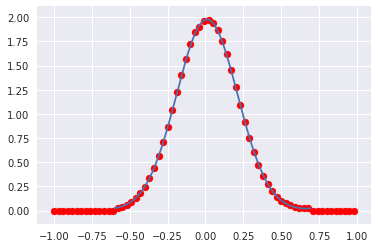

In [281]:
# this should look aligned
newf,newax = plt.subplots()
newax.plot(linedata[0], linedata[1])
xs = np.arange(-1, 1, step=.03)
ys = [get_kde_intersection_yval(x, linedata[0], linedata[1]) for x in xs]
newax.scatter(xs, ys, c='r')

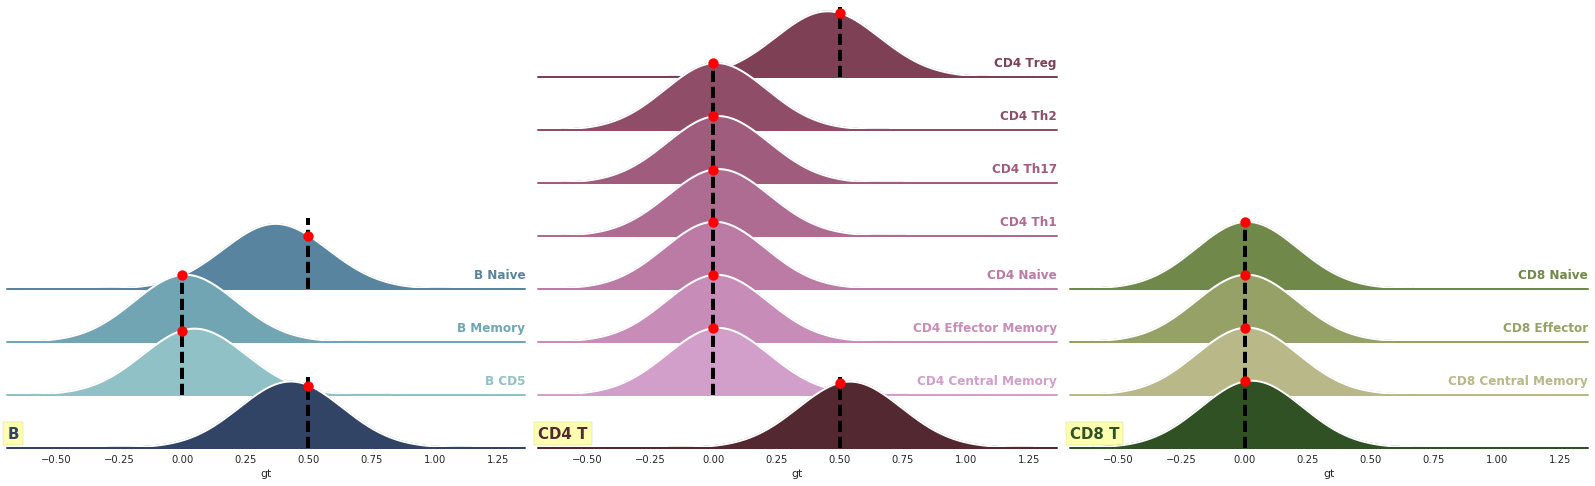

In [285]:
with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    g = sns.FacetGrid(merged_grp,
                      row="ylevel", # subset_name
                      hue="subset_name",
                      col="supertype",
                      row_order=reversed(list(range(grp.ylevel.values.max()+1))),
                      #row_order=hue_order,
                      hue_order=hue_order,
                      aspect=15,
                      size=.5,
                      palette=built_palette
                      #sharey=False
                     )

    ## Draw the densities in a few steps
    # this is the shaded area
    g.map(sns.kdeplot, "estimate", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
    # this is the outline line of the top of the distribution
    g.map(sns.kdeplot, "estimate", clip_on=False, color="w", lw=2, bw=.2) 
    # this is the dividing horizontal line
    g.map(plt.axhline, y=0, lw=2, clip_on=False)
    
    def label(*args, **kwargs):
        """
        args[0] is a Series that corresponds to this facet. it will have values "subset" or "rollup"
        kwargs is e.g.: {'color': (0.4918017777777778, 0.25275644444444445, 0.3333333333333333), 'label': 'CD4 Treg'}
        """
        #print(args)
        #print(kwargs)
        type_of_label = args[0].values[0]
        color = kwargs['color']
        label = kwargs['label']
        ax = plt.gca() # map() changes current axis a ton
        if type_of_label == 'rollup':
            ax.text(0, .2,
                    label,
                    fontweight="bold",
                    color=color, 
                    ha="left", va="center", transform=ax.transAxes,
                    fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.3)
                   )
        else:
            ax.text(1, .2,
                    label,
                    fontweight="bold",
                    color=color, 
                    ha="right", va="center", transform=ax.transAxes
                   )
        
    g.map(label, "type_x")
    
    def get_kde_intersection_yval(x0, kde_x, kde_y):
        """
        we want to find y value at which kde line
        (defined by [kde_x, kde_y] point collection)
        intersects x=x0
        (kde_x, kde_y are numpy ndarrays)
        """
        if x0 in kde_x:
            # the point actually is in the kde point definition!
            return kde_y[np.where(kde_x == x0)][0]
        elif not (kde_x.min() <= x0 <= kde_x.max()):
            # out of bounds of the kde
            return 0
        else:
            # need to interpolate
            # find the two x values that most closely encircle x0
            # then take average of their y values
            # i.e. linear approximation 
            diffs = np.abs(kde_x - x0)
            idxs = np.argsort(diffs) # like argmin, but multiple outputs -- indexes for sorted order
            argmins = idxs[:2]
            return np.mean(kde_y[argmins])
    
    def plot_gt(gt, **kwargs):
        ax = plt.gca()
        # passed in a gt series
        # all values are the same, since we did a left merge
        # (there's only one gt value per facet)
        xval = gt.values[0]
        # get y value of kde at this xval
        #ymax = 2
        kde_line = ax.get_lines()[0].get_data()
        ymax = get_kde_intersection_yval(xval, kde_line[0], kde_line[1])
        # plot
        ax.scatter([xval], [ymax], s=100, c='r',zorder=10, clip_on=False,
                  label='Ground Truth') # clip_on=F means not clipped by axes limits
        ax.axvline(x=xval, ymin=0, ymax=ymax, lw=4, c='k', ls='dashed') # lw=2
    
    g.map(plot_gt, "gt")
    
#     def confirm_extracting_kde(*args, **kwargs):
#         ax = plt.gca()
#         kde_line = ax.get_lines()[0].get_data()
#         ax.scatter(kde_line[0], kde_line[1], c='r', s=200, zorder=200)
        
#     g.map(confirm_extracting_kde)
        

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    # Instead, disabling overlap.
    # Some `subplots_adjust` line is necessary. without this, nothing appears
    #g.fig.subplots_adjust(hspace=0)

    # Remove axes details that don't play will with overlap
    g.set_titles("")
    #g.set_titles(col_template="{col_name}", row_template="")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    
    # resize
    cur_size = g.fig.get_size_inches()
    increase_vertical = 4 # 3
    g.fig.set_size_inches(cur_size[0], cur_size[1] + increase_vertical)
    g.fig

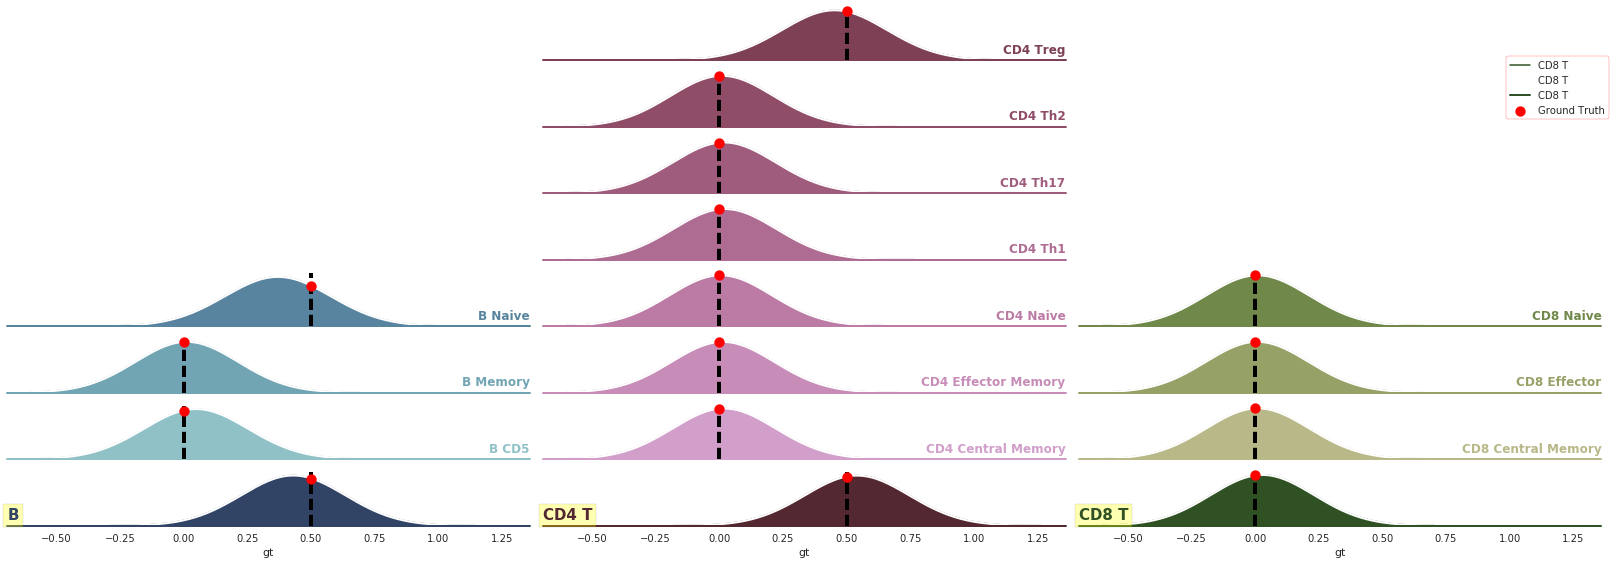

In [295]:
# alternative is: sns.plt.legend(loc='center left',bbox_to_anchor=(1,0.5))... something like that
legend = g.fig.gca().legend(loc='upper right', frameon=True,
                            bbox_to_anchor = (0,-0.1,1,1),
                            bbox_transform = g.fig.transFigure)
# without bbox_to_anchor this gets applied to upper right of the last axis, which is the CD8 T cell bottommost facet
frame = legend.get_frame()
frame.set_edgecolor('red')
frame.set_facecolor('white')
g.fig.tight_layout()
g.fig

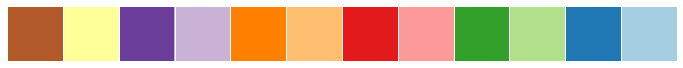

In [297]:
sns.palplot(paired_colors)

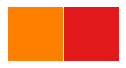

In [298]:
# colors for ground truth and cibersort overlays
sns.palplot([paired_colors[4], paired_colors[6]])

In [312]:
# add cibersort points
cb_base = pd.DataFrame(cib_vals_base).reset_index()
cb_base.columns = ['SubSet', 'estimate']
cb_base['type'] = 'subset'

cb_rolledup = pd.DataFrame(cib_vals_rolledup).reset_index()
cb_rolledup.columns = ['SubSet', 'estimate']
cb_rolledup['type'] = 'rollup'

cb = pd.concat([cb_base, cb_rolledup])
cb.SubSet = cb.SubSet.str.replace('_', ' ') # normalize names

cb = cb.rename(columns={'estimate': 'cb'})
cb.head()

,SubSet,cb,type
0,B CD5,0.290089,subset
1,B Memory,0.000000,subset
2,B Naive,0.046342,subset
3,CD4 Central Memory,0.021105,subset
4,CD4 Effector Memory,0.036781,subset


In [313]:
merged_grp2 = pd.merge(merged_grp, cb, left_on='subset_name', right_on='SubSet', how='left')
merged_grp2.head()

,sample_id,combined_iter_number,subset_name,estimate,type_x,supertype,ylevel,rollup,type_y,gt,SubSet,cb,type
0,7,0,B CD5,0.027472,subset,B,1,B CD5,subset,0.0,B CD5,0.290089,subset
1,7,1,B CD5,0.061270,subset,B,1,B CD5,subset,0.0,B CD5,0.290089,subset
2,7,2,B CD5,0.031252,subset,B,1,B CD5,subset,0.0,B CD5,0.290089,subset
3,7,3,B CD5,0.046982,subset,B,1,B CD5,subset,0.0,B CD5,0.290089,subset
4,7,4,B CD5,0.036124,subset,B,1,B CD5,subset,0.0,B CD5,0.290089,subset


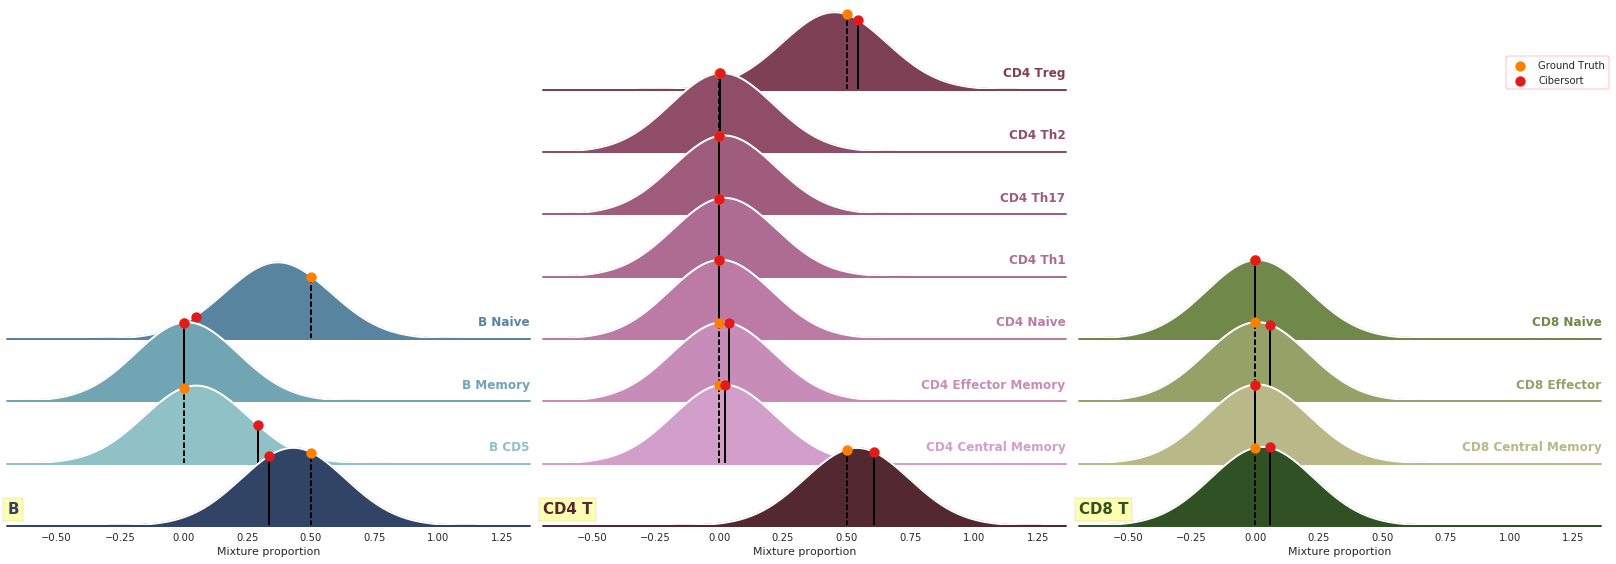

In [320]:
with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    g = sns.FacetGrid(merged_grp2,
                      row="ylevel", # subset_name
                      hue="subset_name",
                      col="supertype",
                      row_order=reversed(list(range(grp.ylevel.values.max()+1))),
                      #row_order=hue_order,
                      hue_order=hue_order,
                      aspect=15,
                      size=.5,
                      palette=built_palette
                      #sharey=False
                     )

    ## Draw the densities in a few steps
    # this is the shaded area
    g.map(sns.kdeplot, "estimate", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
    # this is the outline line of the top of the distribution
    g.map(sns.kdeplot, "estimate", clip_on=False, color="w", lw=2, bw=.2) 
    # this is the dividing horizontal line
    g.map(plt.axhline, y=0, lw=2, clip_on=False)
    
    def label(*args, **kwargs):
        """
        args[0] is a Series that corresponds to this facet. it will have values "subset" or "rollup"
        kwargs is e.g.: {'color': (0.4918017777777778, 0.25275644444444445, 0.3333333333333333), 'label': 'CD4 Treg'}
        """
        #print(args)
        #print(kwargs)
        type_of_label = args[0].values[0]
        color = kwargs['color']
        label = kwargs['label']
        ax = plt.gca() # map() changes current axis a ton
        if type_of_label == 'rollup':
            ax.text(0, .2,
                    label,
                    fontweight="bold",
                    color=color, 
                    ha="left", va="center", transform=ax.transAxes,
                    fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.3)
                   )
        else:
            ax.text(1, .2,
                    label,
                    fontweight="bold",
                    color=color, 
                    ha="right", va="center", transform=ax.transAxes
                   )
        
    g.map(label, "type_x")
    
    def get_kde_intersection_yval(x0, kde_x, kde_y):
        """
        we want to find y value at which kde line
        (defined by [kde_x, kde_y] point collection)
        intersects x=x0
        (kde_x, kde_y are numpy ndarrays)
        """
        if x0 in kde_x:
            # the point actually is in the kde point definition!
            return kde_y[np.where(kde_x == x0)][0]
        elif not (kde_x.min() <= x0 <= kde_x.max()):
            # out of bounds of the kde
            return 0
        else:
            # need to interpolate
            # find the two x values that most closely encircle x0
            # then take average of their y values
            # i.e. linear approximation 
            diffs = np.abs(kde_x - x0)
            idxs = np.argsort(diffs) # like argmin, but multiple outputs -- indexes for sorted order
            argmins = idxs[:2]
            return np.mean(kde_y[argmins])
    
    def plot_point(gt, scattercolor, legendlabel, linestyle, **kwargs):
        """
        custom function to overlay ground truth and cibersort
        method signature is: *args, **kwargs
        make sure not to have any custom kwargs named "color" or "label"
        those are passed in by default related to facet.. avoid
        """
        ax = plt.gca()
        # passed in a gt series
        # all values are the same, since we did a left merge
        # (there's only one gt value per facet)
        xval = gt.values[0]
        # get y value of kde at this xval
        #ymax = 2
        kde_line = ax.get_lines()[0].get_data()
        ymax = get_kde_intersection_yval(xval, kde_line[0], kde_line[1])
        # plot
        ax.scatter([xval], [ymax],
                   s=100,
                   c=scattercolor,
                   zorder=10,
                   clip_on=False, # means not clipped by axis limits (so we see the whole circle)
                   label=legendlabel
                  ) 
        ax.vlines(x=xval, ymin=0, ymax=ymax, linewidths=2, colors='k', linestyles=linestyle)
        # not axvline, because ymin,ymax are in axes coordinates for axvline, not in data coordinates
    
    # ground truth
    g.map(plot_point,
          "gt",
          scattercolor=paired_colors[4],
          legendlabel='Ground Truth',
          linestyle='dashed'
         )
    
    # cibersort 
    g.map(plot_point,
          "cb",
          scattercolor=paired_colors[6],
          legendlabel='Cibersort',
          linestyle='solid'
         )
    
    
    
#     def confirm_extracting_kde(*args, **kwargs):
#         ax = plt.gca()
#         kde_line = ax.get_lines()[0].get_data()
#         ax.scatter(kde_line[0], kde_line[1], c='r', s=200, zorder=200)
        
#     g.map(confirm_extracting_kde)
        

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    # Instead, disabling overlap.
    # Some `subplots_adjust` line is necessary. without this, nothing appears
    #g.fig.subplots_adjust(hspace=0)

    # Remove axes details that don't play will with overlap
    g.set_titles("")
    #g.set_titles(col_template="{col_name}", row_template="")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    
    # fix x axis
    g.set_xlabels('Mixture proportion')
#   g.set_ylabels('Cell type')
#   g.set_xbound(0, 1)
    
    # resize
    cur_size = g.fig.get_size_inches()
    increase_vertical = 4 # 3
    g.fig.set_size_inches(cur_size[0], cur_size[1] + increase_vertical)
    
    # legend
    # alternative is: sns.plt.legend(loc='center left',bbox_to_anchor=(1,0.5))... something like that
    handles, labels = g.fig.gca().get_legend_handles_labels()
    chosen_labels_idx = [labels.index('Ground Truth'),
                         labels.index('Cibersort')
                        ]
    legend = g.fig.gca().legend([handles[i] for i in chosen_labels_idx],
                                [labels[i] for i in chosen_labels_idx],
                                loc='upper right',
                                frameon=True,
                                bbox_to_anchor = (0,-0.1,1,1),
                                bbox_transform = g.fig.transFigure
                               )
    # without bbox_to_anchor this gets applied to upper right of the last axis, which is the CD8 T cell bottommost facet
    frame = legend.get_frame()
    frame.set_edgecolor('red')
    frame.set_facecolor('white')
    
    #g.fig.suptitle("Descriptive title")

    # tighten
    g.fig.tight_layout()
    # then reoverlap
    g.fig.subplots_adjust(hspace=-.1)
    
    # save
    g.savefig("plots/2.1.2_testfig.png", dpi=300)
    g.savefig("plots/2.1.2_testfig.pdf", dpi=300)
    
    # show
    g.fig

# something wrong here

why are kdeplots not in the `[0,1]` range?

In [324]:
grp.subset_name.unique()

array(['B CD5', 'B Memory', 'B Naive', 'CD4 Central Memory',
       'CD4 Effector Memory', 'CD4 Naive', 'CD4 Th1', 'CD4 Th17',
       'CD4 Th2', 'CD4 Treg', 'CD8 Central Memory', 'CD8 Effector',
       'CD8 Naive', 'B', 'CD4 T', 'CD8 T'], dtype=object)

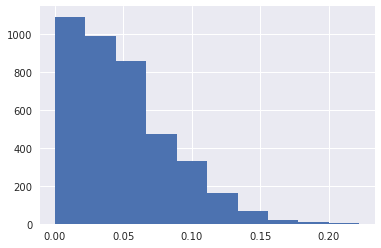

In [329]:
grp[grp['subset_name'] == 'B CD5'].estimate.hist()

In [330]:
grp[grp['subset_name'] == 'B CD5'].estimate.describe()

count    4000.000000
mean        0.048962
std         0.035924
min         0.000053
25%         0.020408
50%         0.042277
75%         0.069036
max         0.222056
Name: estimate, dtype: float64

estimate
count    4000.000000
mean        0.048962
std         0.035924
min         0.000053
25%         0.020408
50%         0.042277
75%         0.069036
max         0.222056
Name: estimate, dtype: float64
{'clip_on': False, 'lw': 2, 'bw': 0.2, 'color': 'w', 'label': 'B CD5'}


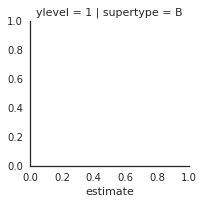

In [336]:
with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    g = sns.FacetGrid(grp[grp['subset_name'] == 'B CD5'],
                      row="ylevel", # subset_name
                      hue="subset_name",
                      col="supertype",
                      #row_order=reversed(list(range(grp.ylevel.values.max()+1))),
                      #row_order=hue_order,
                      #hue_order=hue_order,
                      #aspect=15,
                      #size=.5,
                      #palette=built_palette
                      #sharey=False
                     )

    def mykde(*args, **kwargs):
        #sns.kdeplot(...)
        print(args[0].name)
        print(args[0].describe())
        print(kwargs)
    
    g.map(mykde, "estimate", clip_on=False, color="w", lw=2, bw=.2)

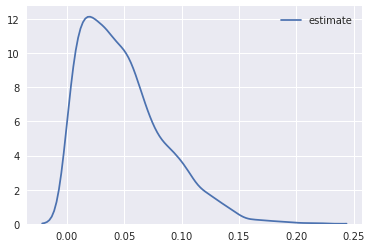

In [331]:
sns.kdeplot(grp[grp['subset_name'] == 'B CD5'].estimate)

turns out it was the `bw` driving things. this is "bandwidth".

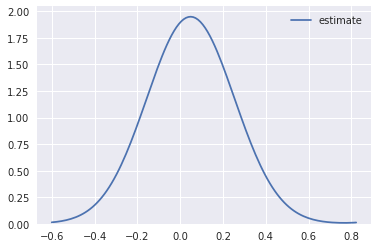

In [339]:
sns.kdeplot(grp[grp['subset_name'] == 'B CD5'].estimate, bw=.2)

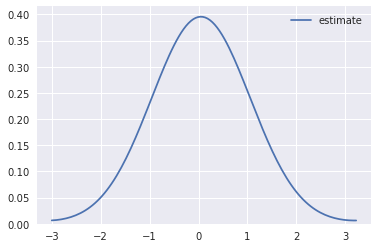

In [340]:
sns.kdeplot(grp[grp['subset_name'] == 'B CD5'].estimate, bw=1)

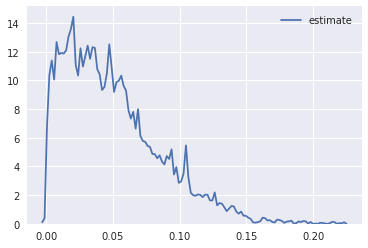

In [341]:
sns.kdeplot(grp[grp['subset_name'] == 'B CD5'].estimate, bw=.001)

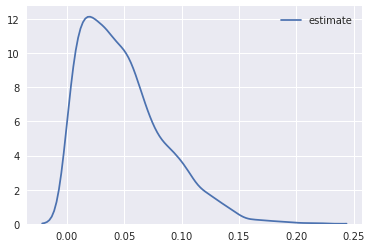

In [342]:
sns.kdeplot(grp[grp['subset_name'] == 'B CD5'].estimate, bw='scott') # default

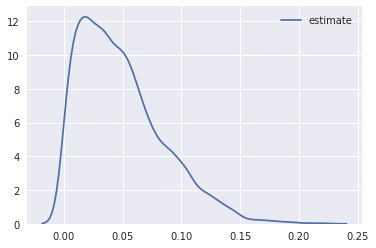

In [343]:
sns.kdeplot(grp[grp['subset_name'] == 'B CD5'].estimate, bw='silverman')

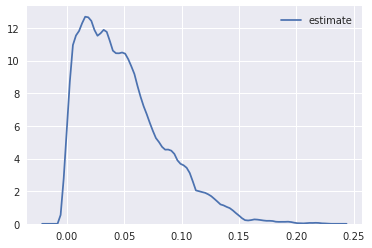

In [352]:
sns.kdeplot(grp[grp['subset_name'] == 'B CD5'].estimate, kernel='epa')

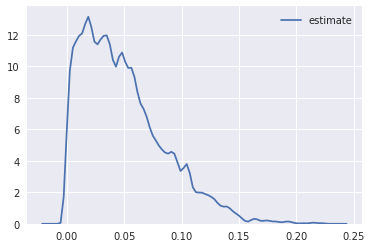

In [353]:
sns.kdeplot(grp[grp['subset_name'] == 'B CD5'].estimate, kernel='triw')

[(-0.01, 1.01)]

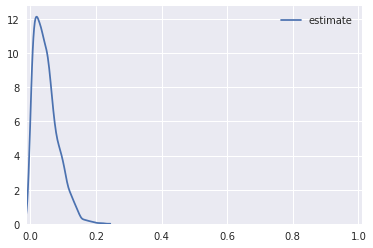

In [360]:
# use the defaults and clip x axis
g=sns.kdeplot(grp[grp['subset_name'] == 'B CD5'].estimate)
#plt.xlim(-0.01, 1.01)
g.set(xlim=(-0.01,1.01))

put those new settings in, and also change horizontal lines to dashed and lower so they don't seem to be long tails for all our distributions

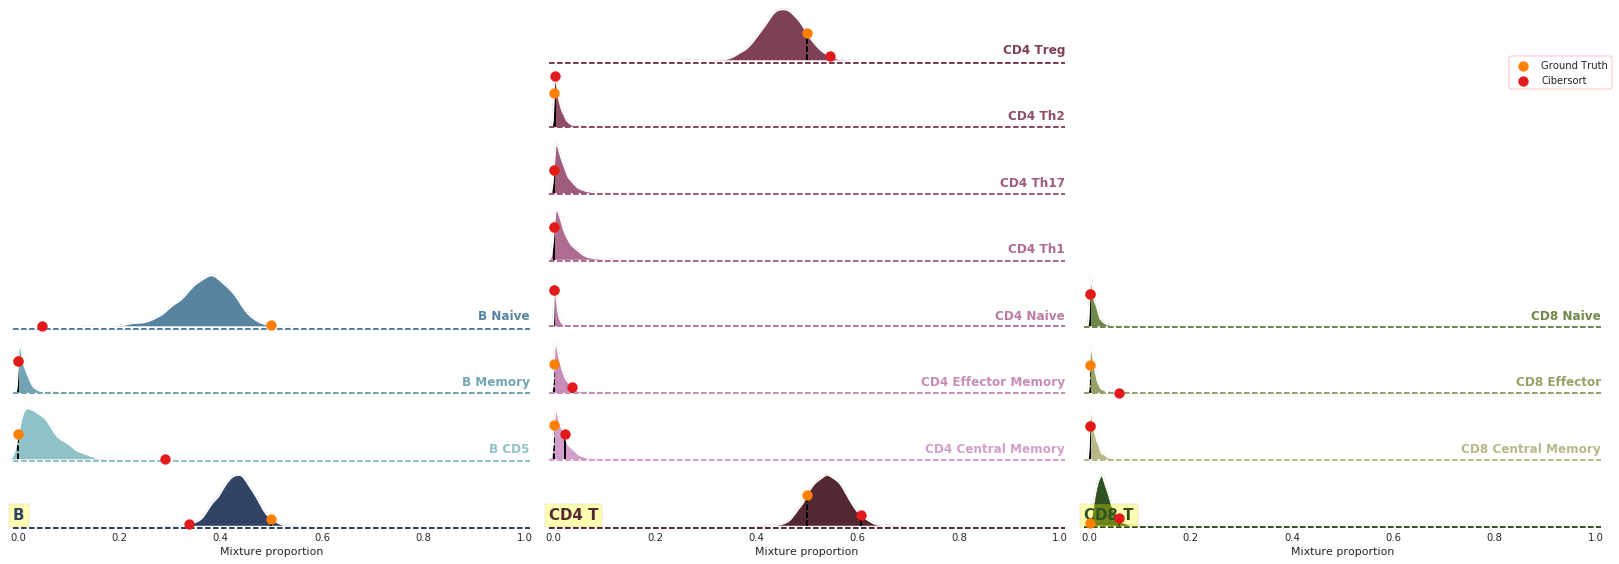

In [379]:
with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    g = sns.FacetGrid(merged_grp2,
                      row="ylevel", # subset_name
                      hue="subset_name",
                      col="supertype",
                      row_order=reversed(list(range(grp.ylevel.values.max()+1))),
                      #row_order=hue_order,
                      hue_order=hue_order,
                      aspect=15,
                      size=.5,
                      palette=built_palette,
                      #sharex=True, # doesn't have an effect
                      sharey=False # important -- they don't share y ranges.
                     )

    ## Draw the densities in a few steps
    # this is the shaded area
    g.map(sns.kdeplot, "estimate", clip_on=False, shade=True, alpha=1, lw=1.5) 
    # this is the outline line of the top of the distribution
    g.map(sns.kdeplot, "estimate", clip_on=False, color="w", lw=2) 
    # this is the dividing horizontal line
    g.map(plt.axhline, y=-0.5, lw=2, clip_on=False, ls='dashed')
    
    def label(*args, **kwargs):
        """
        args[0] is a Series that corresponds to this facet. it will have values "subset" or "rollup"
        kwargs is e.g.: {'color': (0.4918017777777778, 0.25275644444444445, 0.3333333333333333), 'label': 'CD4 Treg'}
        """
        #print(args)
        #print(kwargs)
        type_of_label = args[0].values[0]
        color = kwargs['color']
        label = kwargs['label']
        ax = plt.gca() # map() changes current axis a ton
        if type_of_label == 'rollup':
            ax.text(0, .2,
                    label,
                    fontweight="bold",
                    color=color, 
                    ha="left", va="center", transform=ax.transAxes,
                    fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.3)
                   )
        else:
            ax.text(1, .2,
                    label,
                    fontweight="bold",
                    color=color, 
                    ha="right", va="center", transform=ax.transAxes
                   )
        
    g.map(label, "type_x")
    
    def get_kde_intersection_yval(x0, kde_x, kde_y):
        """
        we want to find y value at which kde line
        (defined by [kde_x, kde_y] point collection)
        intersects x=x0
        (kde_x, kde_y are numpy ndarrays)
        """
        if x0 in kde_x:
            # the point actually is in the kde point definition!
            return kde_y[np.where(kde_x == x0)][0]
        elif not (kde_x.min() <= x0 <= kde_x.max()):
            # out of bounds of the kde
            return 0
        else:
            # need to interpolate
            # find the two x values that most closely encircle x0
            # then take average of their y values
            # i.e. linear approximation 
            diffs = np.abs(kde_x - x0)
            idxs = np.argsort(diffs) # like argmin, but multiple outputs -- indexes for sorted order
            argmins = idxs[:2]
            return np.mean(kde_y[argmins])
    
    def plot_point(gt, scattercolor, legendlabel, linestyle, **kwargs):
        """
        custom function to overlay ground truth and cibersort
        method signature is: *args, **kwargs
        make sure not to have any custom kwargs named "color" or "label"
        those are passed in by default related to facet.. avoid
        """
        ax = plt.gca()
        # passed in a gt series
        # all values are the same, since we did a left merge
        # (there's only one gt value per facet)
        xval = gt.values[0]
        # get y value of kde at this xval
        #ymax = 2
        kde_line = ax.get_lines()[0].get_data()
        ymax = get_kde_intersection_yval(xval, kde_line[0], kde_line[1])
        # plot
        ax.scatter([xval], [ymax],
                   s=100,
                   c=scattercolor,
                   zorder=10,
                   clip_on=False, # means not clipped by axis limits (so we see the whole circle)
                   label=legendlabel
                  ) 
        ax.vlines(x=xval, ymin=0, ymax=ymax, linewidths=2, colors='k', linestyles=linestyle)
        # not axvline, because ymin,ymax are in axes coordinates for axvline, not in data coordinates
    
    # ground truth
    g.map(plot_point,
          "gt",
          scattercolor=paired_colors[4],
          legendlabel='Ground Truth',
          linestyle='dashed'
         )
    
    # cibersort 
    g.map(plot_point,
          "cb",
          scattercolor=paired_colors[6],
          legendlabel='Cibersort',
          linestyle='solid'
         )
    
    
    
#     def confirm_extracting_kde(*args, **kwargs):
#         ax = plt.gca()
#         kde_line = ax.get_lines()[0].get_data()
#         ax.scatter(kde_line[0], kde_line[1], c='r', s=200, zorder=200)
        
#     g.map(confirm_extracting_kde)
        

    # change x axis ranges
    #g.map(lambda: plt.gca().set_xlim(-0.05, 1.05))
    g.set(xlim=(-0.01, 1.01))
    
    # change y axis ranges
    #g.map(lambda *args, **kwargs: plt.gca().set_ylim(plt.gca().get_ybound()))
    #g.map(lambda estimate,**kwargs: plt.gca().set_ylim(0, estimate.max()), "estimate")
    g.set(ylim=(0,None))
    
    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    # Instead, disabling overlap.
    # Some `subplots_adjust` line is necessary. without this, nothing appears
    #g.fig.subplots_adjust(hspace=0)

    # Remove axes details that don't play will with overlap
    g.set_titles("")
    #g.set_titles(col_template="{col_name}", row_template="")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    
    # fix x axis
    g.set_xlabels('Mixture proportion')
#   g.set_ylabels('Cell type')
#   g.set_xbound(0, 1)
    
    # resize
    cur_size = g.fig.get_size_inches()
    increase_vertical = 4 # 3
    g.fig.set_size_inches(cur_size[0], cur_size[1] + increase_vertical)
    
    # legend
    # alternative is: sns.plt.legend(loc='center left',bbox_to_anchor=(1,0.5))... something like that
    handles, labels = g.fig.gca().get_legend_handles_labels()
    chosen_labels_idx = [labels.index('Ground Truth'),
                         labels.index('Cibersort')
                        ]
    legend = g.fig.gca().legend([handles[i] for i in chosen_labels_idx],
                                [labels[i] for i in chosen_labels_idx],
                                loc='upper right',
                                frameon=True,
                                bbox_to_anchor = (0,-0.1,1,1),
                                bbox_transform = g.fig.transFigure
                               )
    # without bbox_to_anchor this gets applied to upper right of the last axis, which is the CD8 T cell bottommost facet
    frame = legend.get_frame()
    frame.set_edgecolor('red')
    frame.set_facecolor('white')
    
    #g.fig.suptitle("Descriptive title")

    # tighten
    g.fig.tight_layout()
    # then reoverlap
    #g.fig.subplots_adjust(hspace=-.1)
    
    # save
    g.savefig("plots/2.1.2_testfig.png", dpi=300)
    g.savefig("plots/2.1.2_testfig.pdf", dpi=300)
    
    # show
    g.fig

In [402]:
for ax in g.axes.flatten():
    if len(ax.texts) > 0:
        print(ax.texts[0].get_text(), ax.get_ylim())
    else:
        print("Unknown:", ax.get_ylim())

Unknown: (0.0, 1.0)
CD4 Treg (0.0, 9.8826990783171507)
Unknown: (0.0, 1.0)
Unknown: (0.0, 1.0)
CD4 Th2 (0.0, 69.454271506713852)
Unknown: (0.0, 1.0)
Unknown: (0.0, 1.0)
CD4 Th17 (0.0, 39.503754234453552)
Unknown: (0.0, 1.0)
Unknown: (0.0, 1.0)
CD4 Th1 (0.0, 34.017015698163455)
Unknown: (0.0, 1.0)
B Naive (0.0, 8.3314154552205366)
CD4 Naive (0.0, 139.35145354357573)
CD8 Naive (0.0, 74.984746997308136)
B Memory (0.0, 59.07213329526877)
CD4 Effector Memory (0.0, 52.426623145621484)
CD8 Effector (0.0, 84.294612378740482)
B CD5 (0.0, 12.742088353521103)
CD4 Central Memory (0.0, 40.285245849037096)
CD8 Central Memory (0.0, 69.536966804483868)
B (0.0, 11.793805045528353)
CD4 T (0.0, 11.034288679037294)
CD8 T (0.0, 30.661625697035209)
